# Experiments with real data (Heart Disease)

https://archive.ics.uci.edu/dataset/45/heart+disease

## Requirements

In [3]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_heart_disease_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_heart_disease import get_config as get_config_exp_1_heart_disease
from config_experiment_3_heart_disease import get_config as get_config_exp_3_heart_disease
from config_experiment_4_heart_disease import get_config as get_config_exp_4_heart_disease

## Data exploration


### Conceptual description

| Variable     | Descripción                                                                                           | Tipo                         | Valores                                                                                  |
|--------------|--------------------------------------------------------------------------------------------------------|------------------------------|--------------------------------------------------------------------------------------------------|
| age          | Edad del paciente en años al momento del estudio.                                                      | Numérica (entera)            | 29 – 77                                                                                  |
| sex          | Sexo del paciente.                                                                                     | Binaria                      | `male (1)`, `female (0)`                                                                 |
| cp           | Tipo de dolor torácico experimentado.                                                                 | Categórica nominal           | `typical angina (1)`, `atypical angina (2)`, `non-anginal pain (3)`, `asymptomatic (4)`    |
| trestbps     | Presión arterial en reposo (mm Hg) medida al ingreso hospitalario.                                     | Numérica (entera)            | 94 – 200                                                                                  |
| chol         | Colesterol sérico total (mg/dl).                                                                      | Numérica (entera)            | 126 – 564                                                                                 |
| fbs          | Azúcar en ayunas mayor a 120 mg/dl.                                                                  | Binaria                      | `true (1)`, `false (0)`                                                                   |
| restecg      | Resultados del electrocardiograma (ECG) en reposo.                                                    | Categórica nominal           | `normal (0)`, `ST-T wave abnormality (1)`, `left ventricular hypertrophy (2)`              |
| thalach      | Frecuencia cardíaca máxima alcanzada.                                                                 | Numérica (entera)            | 71 – 202                                                                                  |
| exang        | Angina inducida por ejercicio.                                                                        | Binaria                      | `yes (1)`, `no (0)`                                                                       |
| oldpeak      | Depresión del segmento ST inducida por ejercicio relativa al reposo.                                   | Numérica (continua)          | 0 – 6.2                                                                                    |
| slope        | Pendiente del segmento ST al ejercicio máximo.                                                        | Categórica ordinal           | `upsloping (1)`, `flat (2)`, `downsloping (3)`                                             |
| ca           | Número de vasos principales (0–3) coloreados por fluoroscopia.                                        | Numérica (entera)            | 0 – 3                                                                                      |
| thal         | Resultado del test de talio.                                                                          | Categórica nominal           | `normal (3)`, `fixed defect (6)`, `reversible defect (7)`                                   |
| num (target) | Diagnóstico de enfermedad cardíaca.                                                                  | Binaria (redefinida)         | `ausencia (0)`, `presencia (1)` (originalmente 0 = ausencia, 1–4 = presencia leve a grave) |


### Data reading

In [4]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [5]:
X.head()

age,trestbps,chol,thalach,oldpeak,ca,sex,fbs,exang,cp,restecg,slope,thal
i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64
63,145,233,150,2.3,0.0,1,1,0,1,2,3,6.0
67,160,286,108,1.5,3.0,1,0,1,4,2,2,3.0
67,120,229,129,2.6,2.0,1,0,1,4,2,2,7.0
37,130,250,187,3.5,0.0,1,0,0,3,0,3,3.0
41,130,204,172,1.4,0.0,0,0,0,2,2,1,3.0


In [6]:
X.shape

(297, 13)

In [7]:
y.head(5)

num
i64
0
1
1
0
0


In [8]:
y.shape

(297, 1)

In [9]:
n_clusters

2

In [10]:
print(p1, p2, p3)

6 3 4


In [11]:
encoding

{'num': {2: 1, 3: 1, 4: 1}}

In [12]:
quant_predictors

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

In [13]:
binary_predictors

['sex', 'fbs', 'exang']

In [14]:
multiclass_predictors

['cp', 'restecg', 'slope', 'thal']

### Data description

In [15]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [16]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
age,41,0.0,54.542088,9.049736,29.0,42.0,48.0,56.0,61.0,66.0,77.0,2.466854,-0.218663,0.0
trestbps,50,0.0,131.693603,17.762806,94.0,110.0,120.0,130.0,140.0,152.0,200.0,3.781192,0.696529,0.030303
chol,152,0.0,247.350168,51.997583,126.0,192.0,211.0,243.0,276.0,309.0,564.0,7.349479,1.112441,0.016835
thalach,91,0.0,149.599327,22.941562,71.0,116.0,133.0,153.0,166.0,177.0,202.0,2.928885,-0.533826,0.003367
oldpeak,40,0.0,1.055556,1.166123,0.0,0.0,0.0,0.8,1.6,2.8,6.2,4.46552,1.240824,0.016835
ca,4,0.0,0.676768,0.938965,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.211157,1.173582,0.06734


In [17]:
cat_summary

,n_unique,perc_nan,mode
sex,2,0.0,1
fbs,2,0.0,0
exang,2,0.0,0
cp,4,0.0,4
restecg,3,0.0,0
slope,3,0.0,1
thal,3,0.0,3.0


In [18]:
y.describe()

statistic,num
str,f64
"""count""",297.0
"""null_count""",0.0
"""mean""",0.461279
"""std""",0.49934
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [19]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = counts/len(y)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.5387205387205387, 1: 0.4612794612794613}


In [20]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""age""",28.5,80.5,0,297,0.0,1.0
"""trestbps""",90.0,170.0,9,288,0.030303,0.969697
"""chol""",113.5,373.5,5,292,0.016835,0.983165
"""thalach""",83.5,215.5,1,296,0.003367,0.996633
"""oldpeak""",-2.4,4.0,5,292,0.016835,0.983165
"""ca""",-1.5,2.5,20,277,0.06734,0.93266


In [21]:
outliers_df['prop_outliers'].mean()

0.02244668911335578

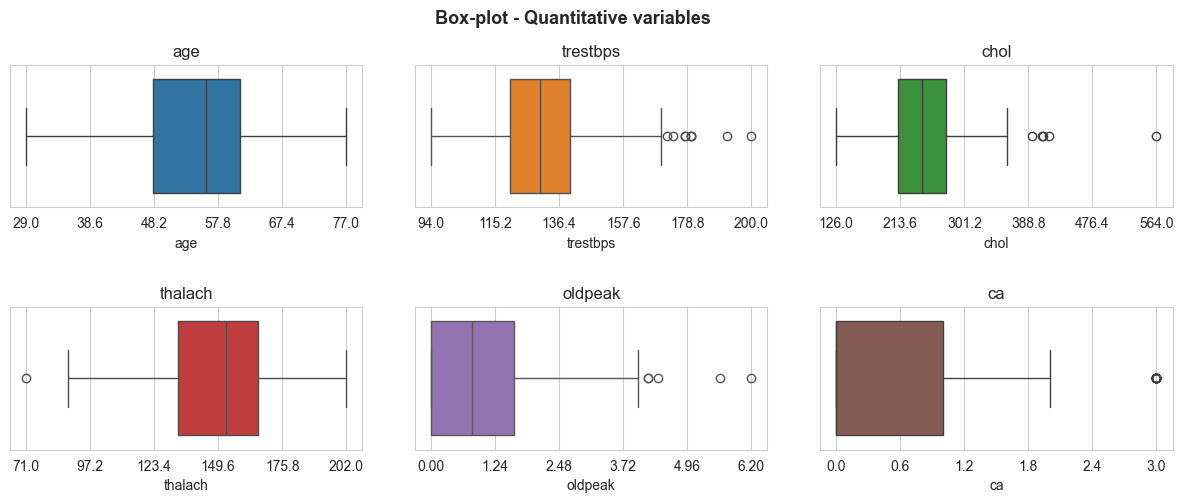

In [22]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,5), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

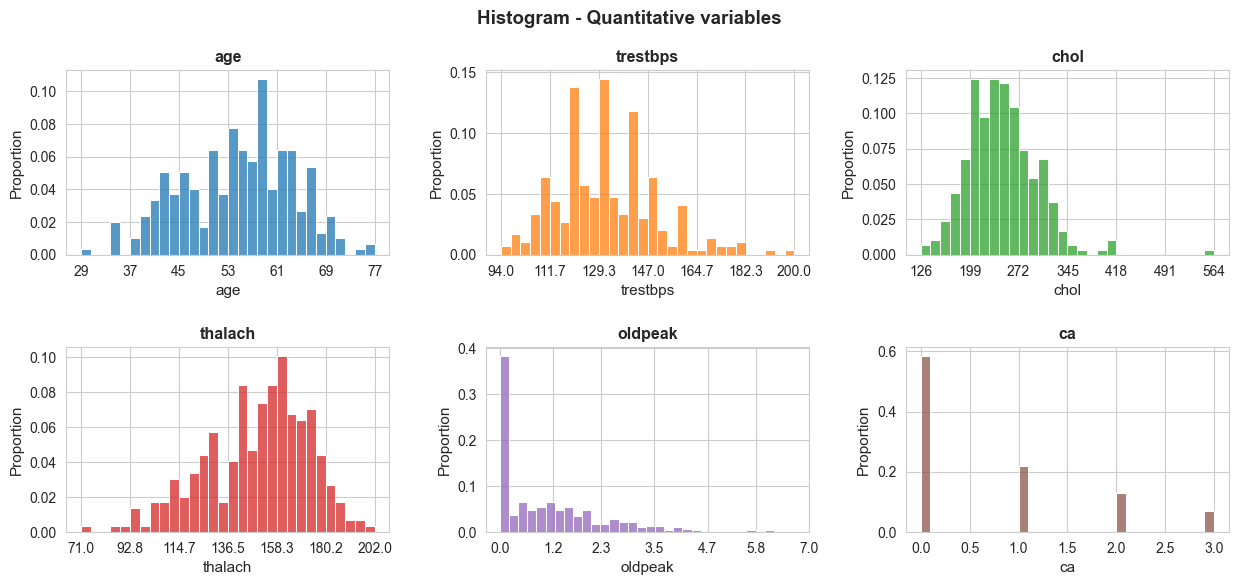

In [23]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,6), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

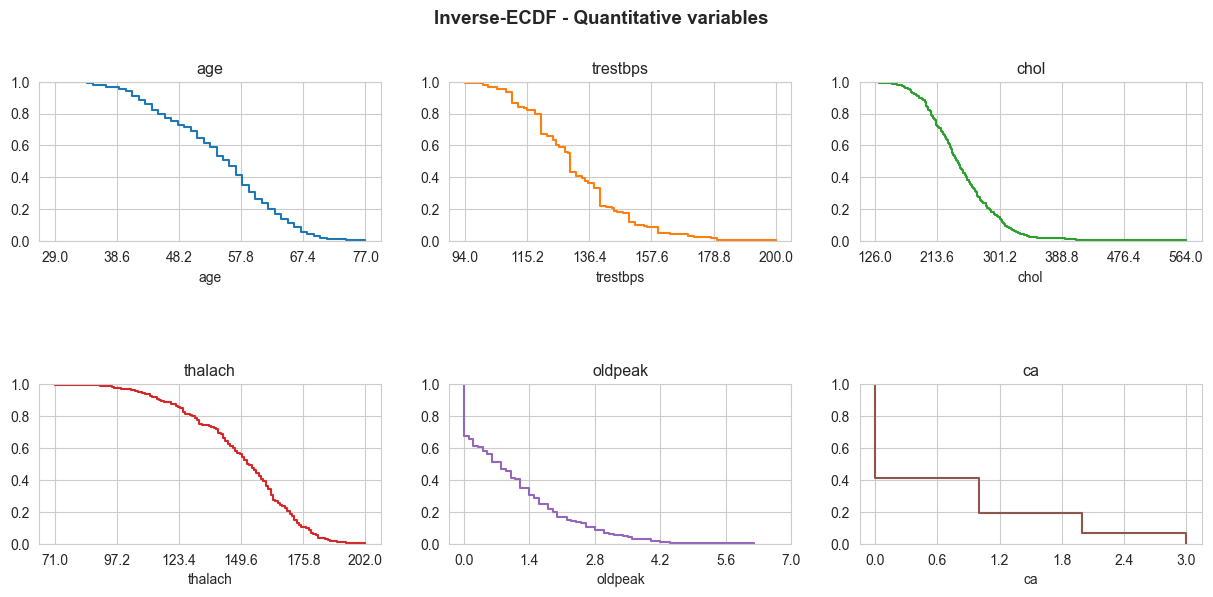

In [24]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

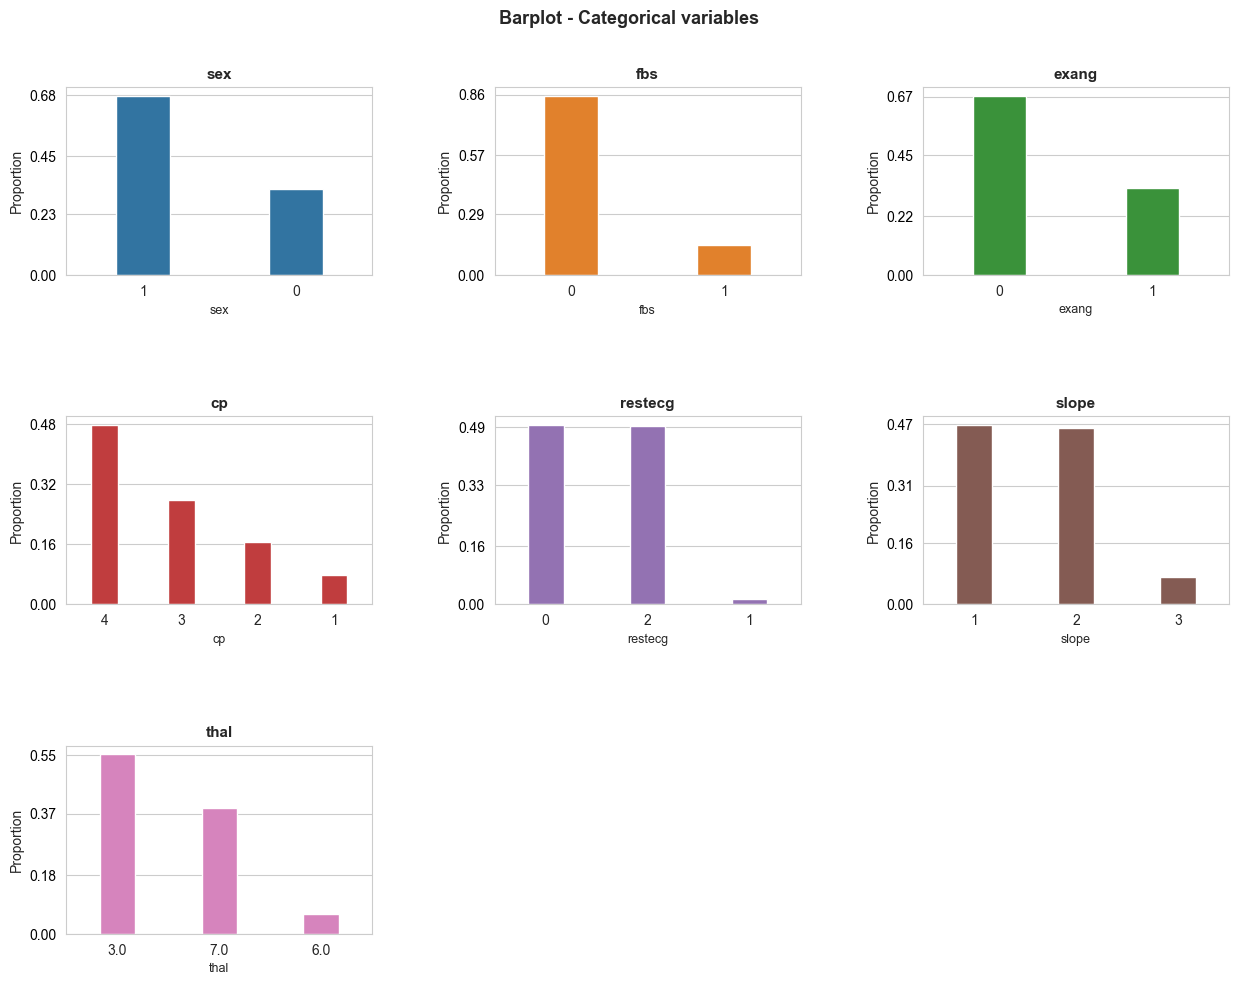

In [25]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,11), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [26]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,age,trestbps,chol,thalach,oldpeak,ca
age,1.000000,0.290476,0.202644,-0.394563,0.197123,0.362210
trestbps,0.290476,1.000000,0.131536,-0.049108,0.191243,0.097954
chol,0.202644,0.131536,1.000000,-0.000075,0.038596,0.115945
thalach,-0.394563,-0.049108,-0.000075,1.000000,-0.347640,-0.268727
oldpeak,0.197123,0.191243,0.038596,-0.347640,1.000000,0.294452
ca,0.362210,0.097954,0.115945,-0.268727,0.294452,1.000000


In [27]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.0
Proportion of pair-wise correlations in [0.30, 0.60]:  0.2
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.8


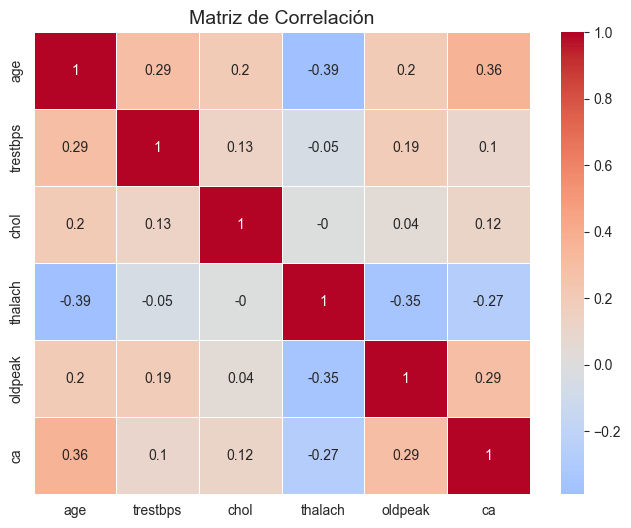

In [29]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()



## Experiment 1


In [26]:
run_experiment_1 = True

In [69]:
if run_experiment_1: 
        
    n_realizations = 25
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_1', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_heart_disease()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [ ]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

In [70]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_1', 'heart_disease')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [71]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_1', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [72]:
experiment_1_config = get_config_exp_1_heart_disease()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [73]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

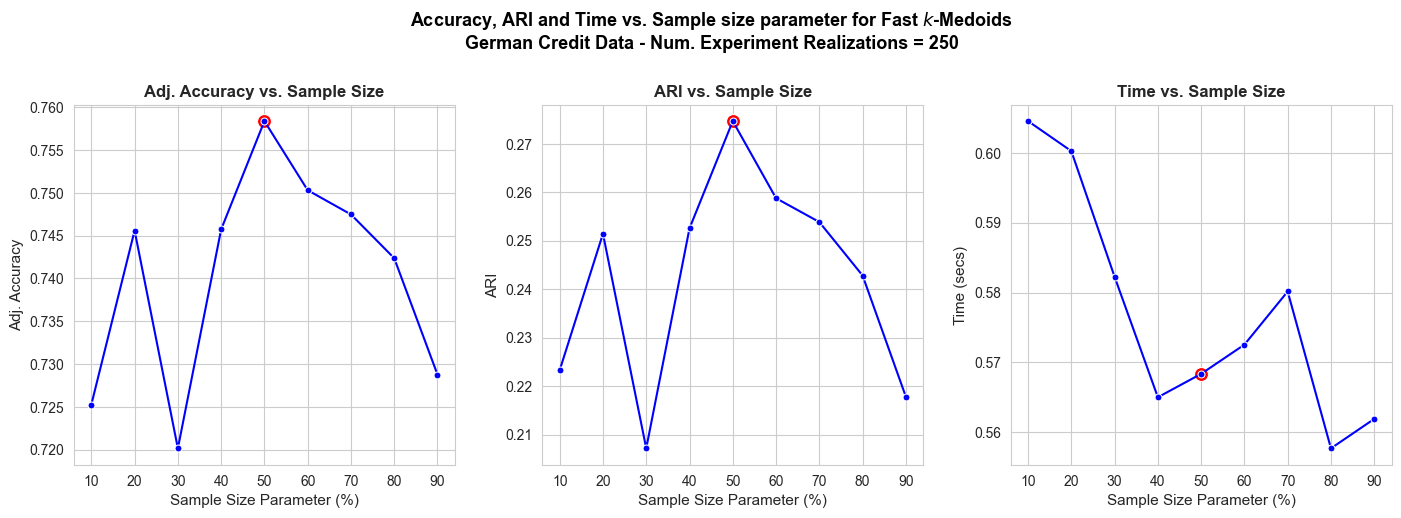

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [75]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.1,0.604533,0.725253,0.223281
0.2,0.600241,0.745589,0.251442
0.3,0.582251,0.720135,0.207151
0.4,0.565012,0.745724,0.252553
0.5,0.568358,0.758384,0.274684
0.6,0.572540,0.750303,0.258766
0.7,0.580148,0.747475,0.253857
0.8,0.557698,0.742357,0.242814
0.9,0.561909,0.728754,0.217806


In [76]:
print(best_frac_sample_size)

0.5



## Experiment 3


In [11]:
run_experiment_3 = True

In [13]:
if run_experiment_3: 

    n_realizations = 25
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_3', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_heart_disease()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [29]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 25 realizations: 87 mins

chunks:   0%|          | 0/9 [00:00<?, ?chunks/s]

random_state_chunk: [1715, 8771, 2856]
random_state: 1715
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


random_state: 8771
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


random_state: 2856
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.9


chunks:  11%|█         | 1/9 [05:24<43:19, 324.89s/chunks]

random_state_chunk: [13344, 8734, 3529]
random_state: 13344
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


random_state: 8734
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


random_state: 3529
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.9


chunks:  22%|██▏       | 2/9 [11:13<39:31, 338.72s/chunks]

random_state_chunk: [1250, 12423, 17570]
random_state: 1250
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


random_state: 12423
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


random_state: 17570
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.43s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.9


chunks:  33%|███▎      | 3/9 [23:34<52:14, 522.40s/chunks]

random_state_chunk: [18426, 10885, 11167]
random_state: 18426
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


random_state: 10885
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


random_state: 11167
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.9


chunks:  44%|████▍     | 4/9 [37:21<53:33, 642.76s/chunks]

random_state_chunk: [1700, 5231, 4425]
random_state: 1700
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


random_state: 5231
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


random_state: 4425
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.29s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.9


chunks:  56%|█████▌    | 5/9 [51:26<47:42, 715.66s/chunks]

random_state_chunk: [11049, 18381, 10937]
random_state: 11049
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


random_state: 18381
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


random_state: 10937
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


frac_sample_size: 0.9


chunks:  67%|██████▋   | 6/9 [1:05:29<37:57, 759.12s/chunks]

random_state_chunk: [22992, 8033, 5366]
random_state: 22992
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


random_state: 8033
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


random_state: 5366
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [03:37<00:00, 43.59s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.9


chunks:  78%|███████▊  | 7/9 [1:21:39<27:36, 828.07s/chunks]

random_state_chunk: [54, 14295, 2870]
random_state: 54
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.48it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


random_state: 14295
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


random_state: 2870
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


frac_sample_size: 0.9


chunks:  89%|████████▉ | 8/9 [1:26:21<10:53, 653.97s/chunks]

random_state_chunk: [19582]
random_state: 19582
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


frac_sample_size: 0.9


chunks: 100%|██████████| 9/9 [1:27:54<00:00, 586.03s/chunks]


In [14]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [15]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_3', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [16]:
config_exp_3 = get_config_exp_3_heart_disease()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

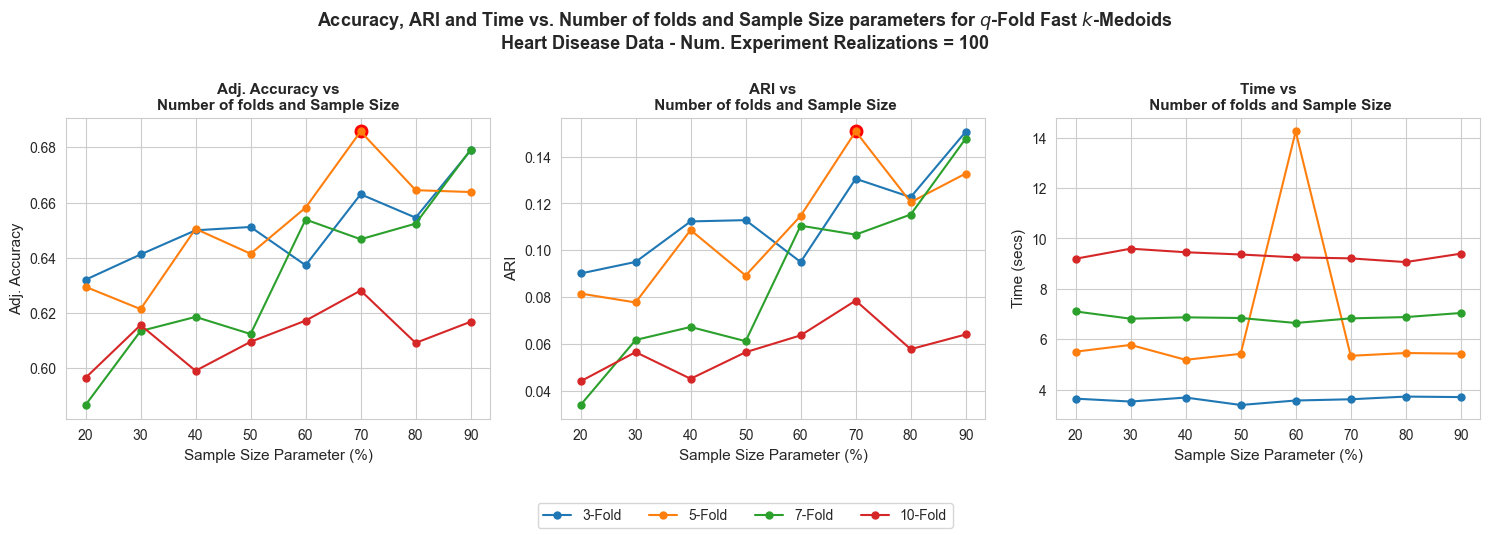

In [18]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_heart_disease_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [19]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,3,0.2,0.632054,0.090083,3.647360
1,3,0.3,0.641212,0.095014,3.532102
2,3,0.4,0.649966,0.112326,3.691309
3,3,0.5,0.651178,0.112873,3.395658
4,3,0.6,0.637306,0.094988,3.573313
5,3,0.7,0.663030,0.130556,3.622371
6,3,0.8,0.654545,0.122697,3.729356
7,3,0.9,0.678923,0.150647,3.709000
8,5,0.2,0.629495,0.081502,5.510238
9,5,0.3,0.621414,0.077689,5.778278


In [20]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 1.684 
 best_n_splits 5.0 
 best_frac_sample_size 0.7



## Experiment 4

In [25]:
config_exp_4 = get_config_exp_4_heart_disease()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 45
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:

    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),

        'DipInit': DipInit(n_clusters=config_exp_4['n_clusters'],
                            random_state=random_state),

        'SpectralClustering': SpectralClustering(n_clusters=config_exp_4['n_clusters'],
                                                 random_state=random_state)

 
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            
        models[random_state][f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [21]:
run_experiment_4 = True

In [7]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', '..', 'results', 'results_experiment_4', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [8]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=accuracy_score)

        # Save results
        results_filename = f'results_exp_4_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 25 realizations: 14 mins

chunks:   0%|          | 0/15 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [3431, 17542, 5713]
random_state: 3431
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[4.09119421e-06 3.32538019e-04 2.48221001e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.0001949500716054488.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.09119421e-06 3.32538020e-04 2.48221001e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


random_state: 17542
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[4.31969799e-06 4.90549436e-04 4.22478470e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.00030578253476346365.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.31969799e-06 4.90549436e-04 4.22478470e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


random_state: 5713
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[4.60714372e-11 3.25405067e-05 1.70114453e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 24 instead with accuracy 
1.1413899108449553e-05.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.93575816e-11 3.25405002e-05 1.70127017e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   7%|▋         | 1/15 [01:14<17:27, 74.81s/chunks]

chunk_id 1
random_state_chunk: [26688, 17468, 7058]
random_state: 26688
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[3.33206558e-06 2.61421016e-04 1.58579461e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00014111084740356817.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.33206558e-06 2.61421016e-04 1.58579461e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


random_state: 17468
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 22 with accuracies 
[1.05259305e-06 1.25715223e-06 9.07320464e-05]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 22 instead with accuracy 
3.1013930560373335e-05.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.05259303e-06 1.25715225e-06 9.07320464e-05]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


random_state: 7058
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[3.49803321e-06 3.57772838e-04 5.55083956e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.00030545160899320736.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.49803321e-06 3.57772838e-04 5.55083956e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  13%|█▎        | 2/15 [02:26<15:47, 72.85s/chunks]

chunk_id 2
random_state_chunk: [2500, 24846, 35140]
random_state: 2500
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[3.19894126e-06 4.21725890e-04 3.99915440e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.000274946756892576.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.19894126e-06 4.21725890e-04 3.99915440e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


random_state: 24846
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 28 with accuracies 
[1.22824315e-06 2.98343881e-04 2.44698648e-02]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 28 instead with accuracy 
0.00825647896329609.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.22824315e-06 2.98343881e-04 2.44698648e-02]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


random_state: 35140
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 112 with accuracies 
[1.17225056e-05 4.15614826e-06 5.81528579e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 111 instead with accuracy 
0.00019898437071629992.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.15308955e-05 6.49202027e-06 5.78930194e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  20%|██        | 3/15 [03:41<14:46, 73.91s/chunks]

chunk_id 3
random_state_chunk: [36852, 21770, 22334]
random_state: 36852
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 36 with accuracies 
[4.14081553e-06 1.49700533e-06 7.73048300e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 35 instead with accuracy 
0.0002506127127401132.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.56148505e-06 1.41097569e-06 7.45865678e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


random_state: 21770
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[3.37539706e-06 3.61401782e-04 1.57779939e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
0.000647525523185166.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.37539706e-06 3.61401782e-04 1.57779939e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


random_state: 22334
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  27%|██▋       | 4/15 [05:10<14:39, 79.93s/chunks]

chunk_id 4
random_state_chunk: [3401, 10463, 8851]
random_state: 3401
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


random_state: 10463
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


random_state: 8851
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.48203517e-06 2.32576122e-04 2.19174850e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00015141100235093068.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.48203517e-06 2.32576122e-04 2.19174850e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  33%|███▎      | 5/15 [06:34<13:33, 81.36s/chunks]

chunk_id 5
random_state_chunk: [22099, 36763, 21875]
random_state: 22099
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 92 with accuracies 
[4.99947480e-05 2.94141444e-06 5.74291516e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 78 instead with accuracy 
0.00012086104696766306.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.89942834e-05 6.53652841e-06 3.17052327e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


random_state: 36763
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[2.74579974e-06 2.23663592e-04 2.86236930e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0001708821070585204.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.74579974e-06 2.23663592e-04 2.86236930e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


random_state: 21875
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[4.65623795e-12 7.52168251e-06 3.69752391e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
3.7397370277191718e-06.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.60281680e-12 7.52168333e-06 3.69752225e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  40%|████      | 6/15 [08:04<12:38, 84.31s/chunks]

chunk_id 6
random_state_chunk: [16067, 10733, 109]
random_state: 16067
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[1.70500379e-06 1.58836995e-04 1.91915835e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00011748594487951822.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.70500379e-06 1.58836995e-04 1.91915835e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


random_state: 10733
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


random_state: 109
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[4.34422814e-06 1.98179299e-04 4.92229281e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00023158426929997347.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.34422814e-06 1.98179299e-04 4.92229281e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  47%|████▋     | 7/15 [09:26<11:09, 83.65s/chunks]

chunk_id 7
random_state_chunk: [28591, 5741, 39164]
random_state: 28591
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 44 with accuracies 
[9.75003930e-07 2.13723672e-04 1.63134743e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 44 instead with accuracy 
0.00012594447278615456.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[9.75003930e-07 2.13723672e-04 1.63134743e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


random_state: 5741
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


random_state: 39164
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  53%|█████▎    | 8/15 [10:51<09:47, 83.94s/chunks]

chunk_id 8
random_state_chunk: [24746, 4579, 432]
random_state: 24746
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[3.72223466e-06 2.36786152e-04 3.90129390e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.00020467539716899062.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[5.40084003e-06 2.31028400e-04 3.77596951e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


random_state: 4579
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 120 with accuracies 
[3.08698009e-12 6.69541449e-06 3.61198889e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 120 instead with accuracy 
3.4358021550750743e-06.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.07915278e-12 6.69541186e-06 3.61199377e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


random_state: 432
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  60%|██████    | 9/15 [12:12<08:18, 83.01s/chunks]

chunk_id 9
random_state_chunk: [20673, 29381, 6687]
random_state: 20673
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.68767230e-06 1.49814767e-04 2.20127515e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.0001242099850161171.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.68767230e-06 1.49814767e-04 2.20127515e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


random_state: 29381
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


random_state: 6687
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 37 with accuracies 
[3.57067540e-06 1.31752092e-04 2.17180105e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 37 instead with accuracy 
0.00011750095739857616.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.57067540e-06 1.31752092e-04 2.17180105e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  67%|██████▋   | 10/15 [13:28<06:45, 81.00s/chunks]

chunk_id 10
random_state_chunk: [2876, 6079, 43721]
random_state: 2876
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.60598508e-06 2.26370707e-04 4.21002567e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00021665975307876267.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.60598508e-06 2.26370707e-04 4.21002567e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


random_state: 6079
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[4.26330126e-06 2.45069297e-04 6.81669287e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.00031033396180660255.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.26330126e-06 2.45069297e-04 6.81669287e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


random_state: 43721
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.64511771e-06 2.30640280e-04 2.30103655e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.0001544630173904075.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.64511771e-06 2.30640280e-04 2.30103655e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  73%|███████▎  | 11/15 [14:44<05:17, 79.29s/chunks]

chunk_id 11
random_state_chunk: [9317, 8273, 1391]
random_state: 9317
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


random_state: 8273
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 44 with accuracies 
[8.09999577e-12 7.94525088e-06 2.89437032e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 33 instead with accuracy 
2.9048419329140927e-06.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.04411833e-12 3.82945216e-06 4.88507048e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


random_state: 1391
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[3.65681068e-06 3.86814980e-04 7.20222682e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0003702314907088232.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.65681068e-06 3.86814980e-04 7.20222682e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  80%|████████  | 12/15 [16:01<03:56, 78.75s/chunks]

chunk_id 12
random_state_chunk: [19123, 28222, 37578]
random_state: 19123
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


random_state: 28222
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


random_state: 37578
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  87%|████████▋ | 13/15 [17:13<02:33, 76.67s/chunks]

chunk_id 13
random_state_chunk: [31255, 17388, 30755]
random_state: 31255
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


random_state: 17388
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 30 with accuracies 
[3.79326819e-06 2.07312132e-04 3.63244354e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 30 instead with accuracy 
0.0012811829795470273.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.79326819e-06 2.07312132e-04 3.63244354e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


random_state: 30755
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[3.61247820e-06 4.54890380e-04 6.15636458e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.00035804643862554164.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.61247820e-06 4.54890380e-04 6.15636458e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  93%|█████████▎| 14/15 [18:25<01:15, 75.34s/chunks]

chunk_id 14
random_state_chunk: [2408, 19994, 22509]
random_state: 2408
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


random_state: 19994
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 29 with accuracies 
[3.40353860e-06 8.89902867e-04 2.90814052e-02]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 29 instead with accuracy 
0.009991570542498577.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.40353860e-06 8.89902867e-04 2.90814052e-02]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


random_state: 22509
KMeans
CLARA
Diana
LDAKmeans
SubKmeans
GaussianMixture
AgglomerativeClustering
SpectralBiclustering
SpectralCoclustering
Birch
BisectingKMeans
MiniBatchKMeans
KMedoids-euclidean
DipInit
SpectralClustering


c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[3.90105560e-06 1.38418970e-04 2.48690642e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00013033688910408644.

  _, diffusion_map = lobpcg(
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.90105560e-06 1.38418970e-04 2.48690642e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 15/15 [19:38<00:00, 78.53s/chunks]


In [22]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'heart_disease')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [23]:
# Open merged/joined results 

results_filename = f'results_exp_4_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [26]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [27]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

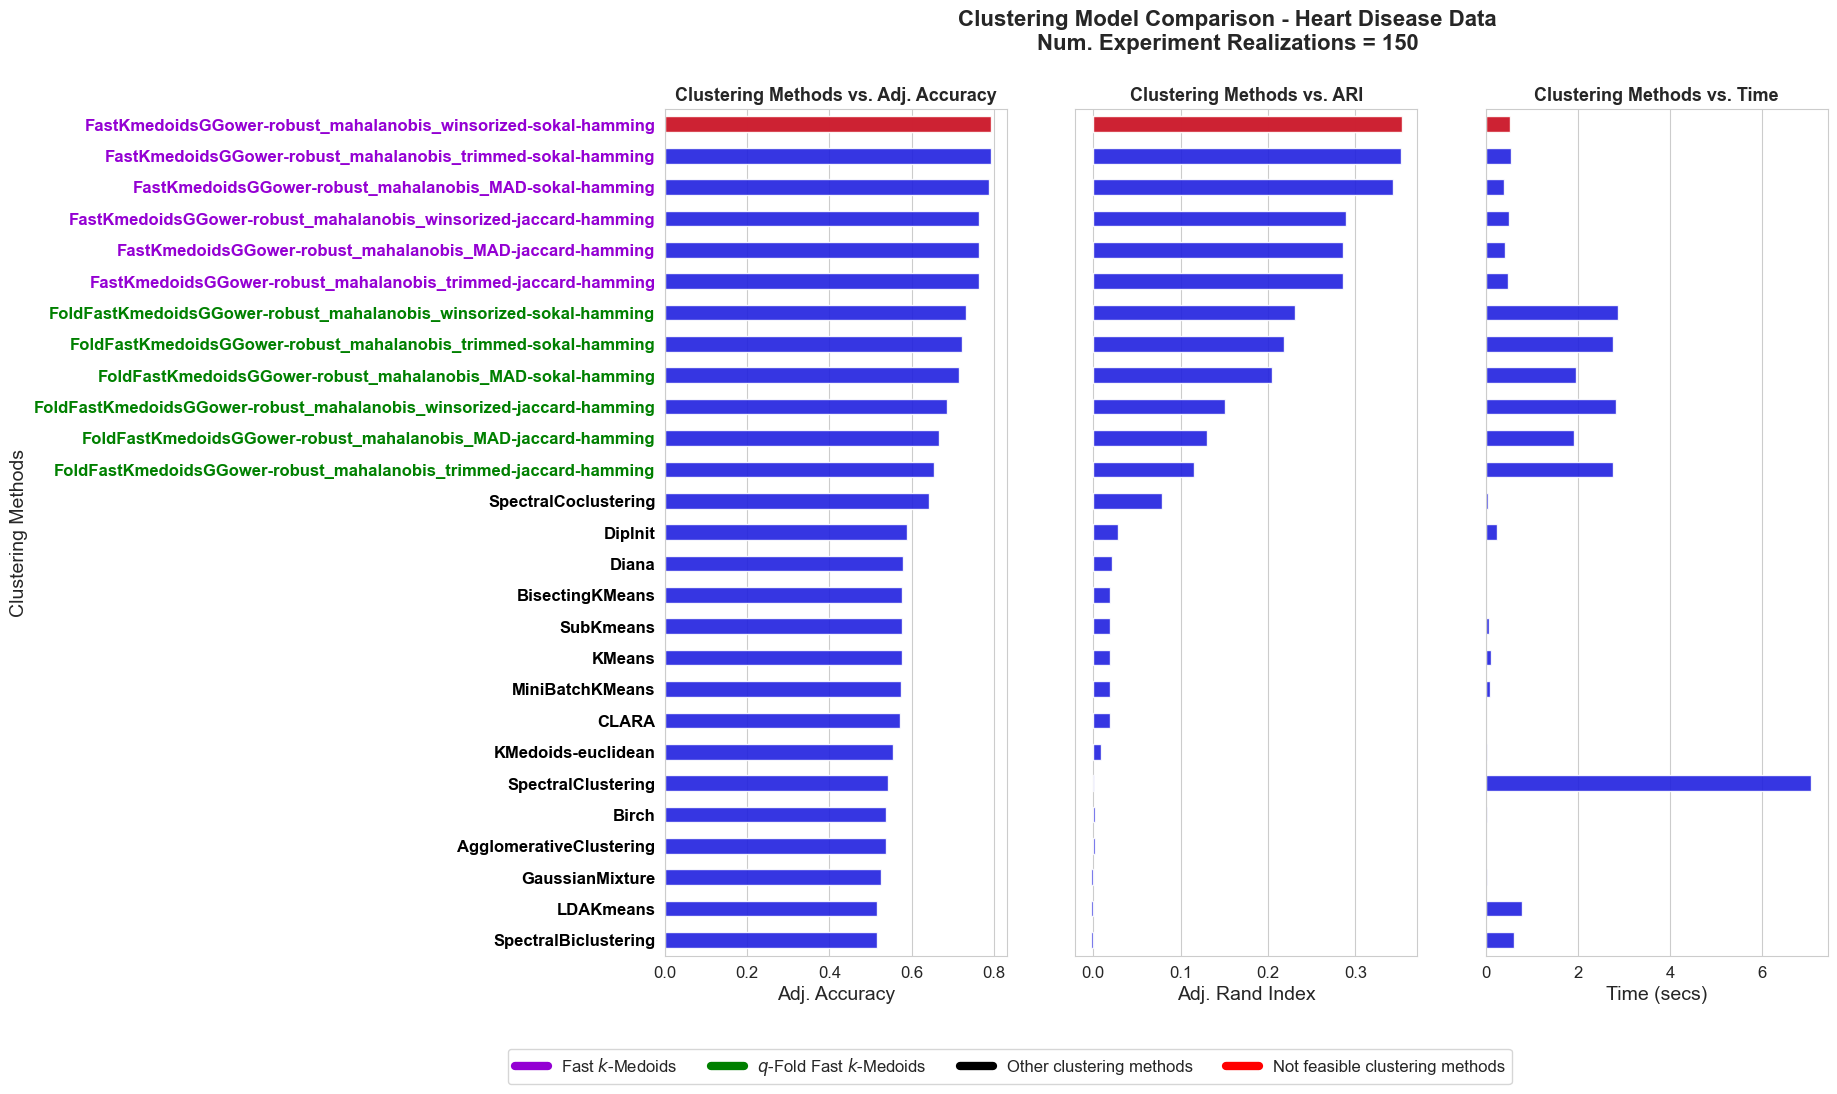

In [28]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Heart Disease Data\nNum. Experiment Realizations = 150", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_heart_disease_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [30]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [31]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,0.535499,0.792742,0.352972
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,0.543099,0.792493,0.352214
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,0.398003,0.789251,0.343450
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,0.496174,0.765058,0.288651
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,0.419278,0.764185,0.285376
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,0.488194,0.763936,0.286119
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,2.863309,0.731263,0.230258
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,2.755475,0.723033,0.218497
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,1.964342,0.716548,0.204395


In [38]:
random_state_mds = 3431

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.8, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [39]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

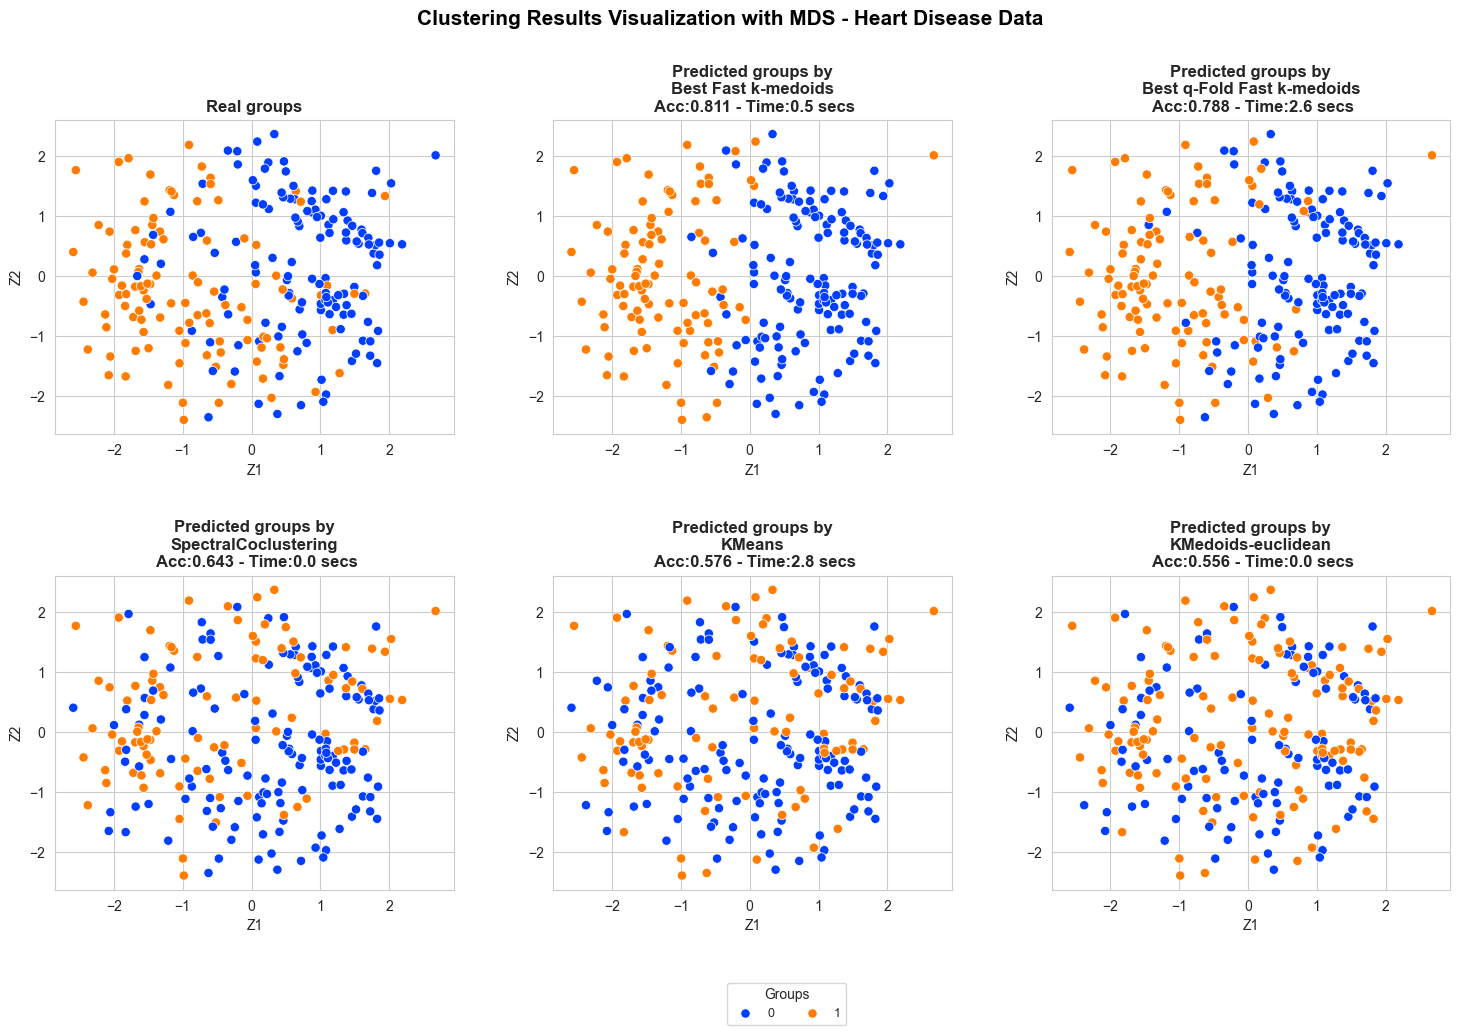

In [40]:
plot_filename = f'mds_plot_exp_4_heart_disease_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', '..', 'results', 'results_experiment_4', 'heart_disease')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Heart Disease Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)